In [1]:
# convenience directory variables
TRAIN_DIR = '/kaggle/input/rsna-2023-abdominal-trauma-detection'

In [2]:
import pandas as pd
import numpy as np
import os
import PIL
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm
import shutil
from functools import partial
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
train = pd.read_csv("/kaggle/input/rsna-2023-abdominal-trauma-detection/train.csv")
train.head()

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury
0,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1
1,10005,1,0,1,0,1,0,0,1,0,0,1,0,0,0
2,10007,1,0,1,0,1,0,0,1,0,0,1,0,0,0
3,10026,1,0,1,0,1,0,0,1,0,0,1,0,0,0
4,10051,1,0,1,0,1,0,0,1,0,0,0,1,0,1


In [4]:
train_series_meta = pd.read_csv("/kaggle/input/rsna-2023-abdominal-trauma-detection/train_series_meta.csv")
print("Number of unique patients in train dataset: ", len(train_series_meta['patient_id'].unique()))
print("Number of samples in train dataset: ", len(train_series_meta['patient_id']))
train_series_meta.head(100)

Number of unique patients in train dataset:  3147
Number of samples in train dataset:  4711


,patient_id,series_id,aortic_hu,incomplete_organ
0,10004,21057,146.00,0
1,10004,51033,454.75,0
2,10005,18667,187.00,0
3,10007,47578,329.00,0
4,10026,29700,327.00,0
...,...,...,...,...
95,11312,51300,179.00,0
96,11313,48992,297.00,0
97,11335,24276,111.00,0
98,11335,39434,216.00,0


In [5]:
image_level_labels = pd.read_csv("/kaggle/input/rsna-2023-abdominal-trauma-detection/image_level_labels.csv")
print("Unique series: ", len(image_level_labels['series_id'].unique()))
series_meta = image_level_labels.merge(train, on=['patient_id'], how='left')

Unique series:  330


In [6]:
series_meta = train_series_meta.drop(['aortic_hu', 'incomplete_organ'], axis=1).merge(train, on=['patient_id'], how='left')
series_meta.head(1000)

,patient_id,series_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury
0,10004,21057,1,0,0,1,0,1,0,1,0,0,0,0,1,1
1,10004,51033,1,0,0,1,0,1,0,1,0,0,0,0,1,1
2,10005,18667,1,0,1,0,1,0,0,1,0,0,1,0,0,0
3,10007,47578,1,0,1,0,1,0,0,1,0,0,1,0,0,0
4,10026,29700,1,0,1,0,1,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2230,20232,1,0,1,0,1,0,0,1,0,0,1,0,0,0
996,2230,42154,1,0,1,0,1,0,0,1,0,0,1,0,0,0
997,2232,4213,1,0,1,0,1,0,0,1,0,0,1,0,0,0
998,22323,16871,1,0,1,0,1,0,0,0,0,1,1,0,0,1


In [7]:
s_1 = series_meta[series_meta['bowel_healthy']==1].sample(n=2)
s_2 = series_meta[series_meta['bowel_injury']==1].sample(n=2)
s_3 = series_meta[series_meta['extravasation_healthy']==1].sample(n=2)
s_4 = series_meta[series_meta['extravasation_injury']==1].sample(n=2)
s_5 = series_meta[series_meta['kidney_healthy']==1].sample(n=2)
s_6 = series_meta[series_meta['kidney_low']==1].sample(n=2)
s_7 = series_meta[series_meta['kidney_high']==1].sample(n=2)
s_8 = series_meta[series_meta['liver_healthy']==1].sample(n=2)
s_9 = series_meta[series_meta['liver_low']==1].sample(n=2)
s_10 = series_meta[series_meta['liver_high']==1].sample(n=2)
s_11 = series_meta[series_meta['spleen_healthy']==1].sample(n=2)
s_12 = series_meta[series_meta['spleen_low']==1].sample(n=2)
s_13 = series_meta[series_meta['spleen_high']==1].sample(n=2)

In [8]:
series_meta = pd.concat([s_1, s_2, s_3, s_4, s_5, s_6,s_7,s_8,s_9,s_10,s_11,s_12,s_13])

In [9]:
assert len(series_meta) == len(series_meta.drop_duplicates())

In [10]:
series_meta.loc[series_meta['kidney_high']==1, 'kidney_low'] = 0.9
series_meta.loc[series_meta['liver_high']==1, 'liver_low'] = 0.9
series_meta.loc[series_meta['spleen_high']==1, 'spleen_low'] = 0.9

In [11]:
series_meta.head(10)

,patient_id,series_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury
2594,41956,15628,1,0,1,0,1,0.0,0,1,0.0,0,1,0.0,0,0
2587,41864,27019,1,0,1,0,1,0.0,0,1,0.0,0,1,0.0,0,0
890,20951,6575,0,1,1,0,1,0.0,0,0,1.0,0,1,0.0,0,1
3565,54371,55647,0,1,0,1,1,0.0,0,1,0.0,0,1,0.0,0,1
1153,24464,40784,1,0,1,0,1,0.0,0,1,0.0,0,1,0.0,0,0
3832,57338,19128,1,0,1,0,1,0.0,0,1,0.0,0,1,0.0,0,0
2181,36686,7792,1,0,0,1,1,0.0,0,1,0.0,0,1,0.0,0,1
143,11925,33599,0,1,0,1,1,0.0,0,1,0.0,0,0,1.0,0,1
3224,49937,45371,1,0,1,0,1,0.0,0,1,0.0,0,1,0.0,0,0
3842,57482,46310,1,0,1,0,1,0.0,0,1,0.0,0,1,0.0,0,0


In [12]:
!pip install -qU python-gdcm pydicom pylibjpeg

In [13]:
#!pip install dicomsdl
import pydicom
#import dicomsdl as dicoml
import nibabel as nib
import time
import numpy as np
import os
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

# Split ct scan into series of n images 
and label them based on injury apperance in frames

In [14]:
from scipy import ndimage
from PIL import Image
import torch

In [15]:
class MDataset(torch.utils.data.Dataset):

    def __init__(self, paths, labels, limit:int = None, filetype:str = 'dcm',
                 normalize:bool = True, im_size:int = 224, select_image:bool = True, resize:bool = True):
        
        self.filetype = filetype
        self.im_size = im_size

        self.select_image = select_image
        self.normalize = normalize
        self.resize = resize
    
        self.samples = paths
        self.labels = labels
        
    def _select_image(self, image, threshold:float = 0.1):
        zero = image[0,0]
        if np.count_nonzero(image!=zero) > int(threshold*image.shape[0] * image.shape[1]) or not self.select_image:
            return True
        return False

    def __getitem__(self, index: int)->tuple[np.ndarray, np.ndarray]:
        if self.filetype == 'dcm':
            image = self._load_dicom(self.samples[index], select_image = self.select_image)
        elif self.filetype == 'jpeg':
            image = self._load_jpeg(self.samples[index])
            
        if image is not None and self.resize:
            image = self._resize_image(image)
        return image, self.labels[index]
    
    def __len__(self):
        return(len(self.samples))
        
    def _resize_image(self, data):
        """
        Resize the data to the input size
        """ 
        [height, width] = data.shape
        scale = [self.im_size*1.0/height, self.im_size*1.0/width]  
        data = ndimage.zoom(data, scale, order=0)

        return data
        
    def _load_jpeg(self, filepath):
        img = np.array(Image.open(filepath), dtype = np.float32)
        if np.max(img) != 0:
            img = img / np.max(img)
            
        return img
        
    def _load_dicom(self, filepath, select_image: bool = False): 
        dicom = pydicom.dcmread(filepath)
        img = self.standardize_pixel_array(dicom)
        img = (img - img.min()) / (img.max() - img.min() + 1e-6)

        if dicom.PhotometricInterpretation == "MONOCHROME1":
            img = 1 - img

        return img
    
    def standardize_pixel_array(self, dcm: pydicom.dataset.FileDataset) -> np.ndarray:
        """
        Source : https://www.kaggle.com/competitions/rsna-2023-abdominal-trauma-detection/discussion/427217
        """
        # Correct DICOM pixel_array if PixelRepresentation == 1.
        pixel_array = dcm.pixel_array
        if dcm.PixelRepresentation == 1:
            bit_shift = dcm.BitsAllocated - dcm.BitsStored
            dtype = pixel_array.dtype 
            pixel_array = (pixel_array << bit_shift).astype(dtype) >>  bit_shift
    #         pixel_array = pydicom.pixel_data_handlers.util.apply_modality_lut(new_array, dcm)

        intercept = float(dcm.RescaleIntercept)
        slope = float(dcm.RescaleSlope)
        center = int(dcm.WindowCenter)
        width = int(dcm.WindowWidth)
        low = center - width / 2
        high = center + width / 2    

        pixel_array = (pixel_array * slope) + intercept
        pixel_array = np.clip(pixel_array, low, high)

        return pixel_array

In [34]:
ROOT_DIR = '/kaggle/input/rsna-2023-atd-reduced-256-5mm'
TRAIN_DIR = f'{ROOT_DIR}/reduced_256_tickness_5'

def get_paths(series_meta, limit = None, extension='.dcm'):
    samples = []
    labels = []
    batches = []
    
    cs = 0
    batch = 0;
    for ind, sample in tqdm(series_meta.iterrows(), total = len(series_meta)):
        segmention_sample = sample['series_id']
        img_dir = f"{TRAIN_DIR}/{int(sample['patient_id'])}/{int(segmention_sample)}"
        
        label = sample[["bowel_healthy","bowel_injury", 
                         "extravasation_healthy", "extravasation_injury",
                         "kidney_healthy", "kidney_low", "kidney_high",
                         "liver_healthy", "liver_low", 'liver_high',
                         "spleen_healthy", "spleen_low", "spleen_high"]].values.tolist()
        
        _filenames = os.listdir(img_dir)
        _filenames = [int(filename.split('.')[0]) for filename in _filenames]
        _filenames = sorted(_filenames)
        _filenames = [f'{img_dir}/{filename}'+extension for filename in _filenames]
        _labels = [label for i in range(len(_filenames))]
        _batches = list(range(batch, batch+len(_filenames)))
        
        samples += _filenames
        labels += _labels
        batches.append(_batches)
        batch += len(_filenames)
        
        cs+=1
        if limit and (cs==limit):
            break
            
    return samples, labels, batches

In [35]:
samples, labels, batches = get_paths(series_meta, limit = None, extension = '.jpeg')

  0%|          | 0/26 [00:00<?, ?it/s]

In [36]:
lens = []
for batch in batches:
    lens.append(len(batch))

print(np.mean(lens))

102.15384615384616


In [37]:
class CBatchSampler():
    def __init__(self, batches, batch_size:int = 2, shuffle:bool=True):
        self.batch_size = batch_size
        self.batches = np.array(batches, dtype='object')
        if shuffle:
            np.random.shuffle(self.batches)
            
        # oversample to make batches%batch_size == 0
        if len(batches)%batch_size !=0:
            self.batches += self.batches[0:batch_size-(len(batches)%batch_size)]

        if batch_size > 1:
            self.batches = [np.concatenate(batch) for batch in np.split(self.batches, len(self.batches)//self.batch_size)]
        # connect *batch_size* arrays together and add len to label
        # in collate split them based on length and return the right batch
        
    def __iter__(self):
        for batch in self.batches:
            yield torch.tensor(batch)

    def __len__(self):
        return len(self.batches)

In [38]:
def drop_invalid_range(volume):
    """
    Cut off the invalid area
    """
    zero_value = volume[0, 0, 0]
    non_zeros_idx = np.where(volume != zero_value)

    [max_z, max_h, max_w] = np.max(np.array(non_zeros_idx), axis=1)
    [min_z, min_h, min_w] = np.min(np.array(non_zeros_idx), axis=1)

    return volume[min_z:max_z, min_h:max_h, min_w:max_w]

def resize_data(data, dimention, im_size):
        """
        Resize the dimention of data
        """ 
        [depth, height, width] = data.shape
        scale = [dimention*1.0/depth, im_size*1.0/height, im_size*1.0/width]  
        data = ndimage.zoom(data, scale, order=0)
        return data
    
def preprocess_collate_fn(original_batch, dimention:int=120, im_size:int = 224):
    # We are assuming that a batch contains all images for one volume
    
    labels = original_batch[0][1]
    volume = np.array([item[0] for item in original_batch if item[0] is not None], dtype=np.float32)
    volume = drop_invalid_range(volume)
    volume = torch.from_numpy(resize_data(volume, dimention, im_size)).unsqueeze(0)
    return volume, torch.tensor(labels, dtype=torch.float).unsqueeze(0)

In [57]:
def get_dataloaders(samples, labels, batches, limit = None, batch_size:int=1, normalize:bool = True, im_size:int = 224,
                 volume_dim: int = 120, select_image:bool = True, pre_resize: bool = False, pre_im_size:int=384, filetype:str = 'jpeg'):
    
    if not pre_im_size and pre_resize:
        pre_im_size = im_size
        
    assert volume_dim%3==0, "Volume dimention must be a multiple of 3."
    assert batch_size==1, "Only batch_size == 1 is supported."
    "Builds a set of dataloaders with a batch_size"
    random_perm = np.random.permutation(len(batches))
    if limit:
        random_perm = random_perm[:limit]
        
    cut = int(0.8 * len(random_perm))

    train_split = random_perm#[:cut]
    eval_split = []#random_perm[cut:]

    
    _dataset = MDataset(samples, labels, limit=limit, normalize=normalize, im_size=im_size, 
                        select_image=select_image, resize = pre_resize, filetype = filetype)
    
    #train_batch_sampler = CBatchSampler([batches[i] for i in train_split], batch_size=1, shuffle=True)
    #eval_batch_sampler = CBatchSampler([batches[i] for i in eval_split], batch_size=1, shuffle=True)
    
    colate_fn = partial(preprocess_collate_fn, dimention=volume_dim, im_size=im_size)
    # Instantiate dataloaders
    train_dataloader = DataLoader(_dataset, batch_sampler=[batches[i] for i in train_split], num_workers=os.cpu_count(), pin_memory = False,
                                 collate_fn=colate_fn)
    eval_dataloader = DataLoader(_dataset, batch_sampler=[batches[i] for i in eval_split], num_workers=os.cpu_count(), pin_memory = False,
                                collate_fn=colate_fn)
    
    return train_dataloader, eval_dataloader

In [22]:
!pip install timm==0.6.11
!git clone https://github.com/sail-sg/metaformer.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.7/548.7 kB 9.7 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: timm
    Found existing installation: timm 0.9.2
    Uninstalling timm-0.9.2:
      Successfully uninstalled timm-0.9.2
Cloning into 'metaformer'...
remote: Enumerating objects: 205, done.
remote: Counting objects: 100% (205/205), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 205 (delta 146), reused 173 (delta 118), pack-reused 0
Receiving objects: 100% (205/205), 364.53 KiB | 3.44 MiB/s, done.
Resolving deltas: 100% (146/146), done.


In [23]:
import torch
import timm
import torch.nn as nn
from functools import partial
import torch.nn.functional as F
from metaformer import metaformer_baselines as mb

In [24]:
# FE
class FE_metaformer(nn.Module):
    def __init__(self, in_channels = 3, im_size=224, dims = [64, 128, 320, 512]):
        super().__init__()
        self.in_channels = in_channels
        self.dims = dims
        self.im_size = im_size
        ###
        backbone = mb.convformer_s18(pretrained=True)
        self.downsamples = list(backbone.children())[0]
        self.metaformers = list(backbone.children())[1]
        
    def forward(self, input):
        # Encoding
        x = input
        for i in range(len(self.dims)):
            x = self.metaformers[i](self.downsamples[i](x))
        #x = self.bnorm2d(x.permute(0,3,1,2))
        return x#.permute(0, 2, 3, 1)

In [25]:
class StarReLU(nn.Module):
    """
    StarReLU: s * relu(x) ** 2 + b
    """
    def __init__(self, scale_value=1.0, bias_value=0.0,
        scale_learnable=True, bias_learnable=True, 
        mode=None, inplace=False):
        super().__init__()
        self.inplace = inplace
        self.relu = nn.ReLU(inplace=inplace)
        self.scale = nn.Parameter(scale_value * torch.ones(1),
            requires_grad=scale_learnable)
        self.bias = nn.Parameter(bias_value * torch.ones(1),
            requires_grad=bias_learnable)
    def forward(self, x):
        return self.scale * self.relu(x)**2 + self.bias

In [26]:
class MlpHead(nn.Module):
    """ MLP classification head
    """
    def __init__(self, dim, num_classes=1000, mlp_ratio=4, act_layer=mb.StarReLU,
        norm_layer=nn.LayerNorm, head_dropout=0., bias=True):
        super().__init__()
        hidden_features = int(mlp_ratio * dim)
        self.fc1 = nn.Linear(dim, hidden_features, bias=bias)
        self.act = act_layer()
        self.norm = norm_layer(hidden_features)
        self.fc2 = nn.Linear(hidden_features, num_classes, bias=bias)
        self.head_dropout = nn.Dropout(head_dropout)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.norm(x)
        x = self.head_dropout(x)
        x = self.fc2(x)
        return x

In [79]:
class CTNetModel(nn.Module):
    """Model for big data. ResNet18 then 3D conv then FC."""
    def __init__(self):
        super(CTNetModel, self).__init__()        
        self.features = nn.DataParallel(FE_metaformer())
        #conv input torch.Size([1,512,70,7,7])

        self.reduction = nn.Sequential(
            nn.Conv3d(40, 32, kernel_size = (7,2,2), stride=(4,1,1), padding=(0, 0, 0)),
            #nn.BatchNorm3d(64),
            nn.GELU(),
            
            nn.Conv3d(32, 16, kernel_size = (7,1,1), stride=(4,1,1), padding=(0, 0, 0)),
            #nn.BatchNorm3d(16),
            nn.GELU(),
            
            nn.Conv3d(16, 16, kernel_size = (3,1,1), stride=(2,1,1), padding=(0, 0, 0)),
            #nn.BatchNorm3d(16),
        )
        
        
        #self.AcE_head = MlpHead(dim = 16*9*7*7, num_classes = 2)
        self.organs_head = nn.Sequential(
            nn.Linear(16*15*6*6, 256),
            nn.ReLU(True),
            nn.Dropout(0.5),
            
            nn.Linear(256, 128), 
            nn.ReLU(True),
            nn.Dropout(0.2),
            
            nn.Linear(128, 13))
        
        #self.softmax = nn.Softmax(dim = 1)
        self.sigmoid = nn.Sigmoid()

        
    def forward(self, x):
        # in [B,D,H,W]
        [B, D, H, W] = x.shape
        #print(x.shape)
        # reshape to [B*D/3, 3, H, W]
        x = x.view(B*(D//3),3,H,W)
        #print(x.shape)
        x = self.features(x)
        #print(x.shape)
        [Bf, H, W, features] = x.shape
        x = x.view(B, Bf//B, H, W, features).permute(0, 1, 4, 2, 3)#.permute(0, 4, 1, 2, 3)
        #print(x.shape)
        x = self.reduction(x)
        
        
        #print(x.shape)
        x = x.reshape(B, 16*15*6*6)
        #print(x.shape)
        
        #ace = self.AcE_head(x)
        organs = self.organs_head(x)
        #print(organs)
        return self.sigmoid(organs)

In [28]:
def construct_network():
    return CTNetModel()

In [29]:
from pathlib import Path
from torch.utils.data import DataLoader
import time
from collections import defaultdict
from sklearn import metrics as mt
from functools import partial

In [30]:
def exists(x):
    return x is not None

def metrics_description(metrics:dict, phase:str)->str:
    outputs = phase + ": ||"
    for k in metrics.keys():
        outputs += (" {}: {:4f} ||".format(k, np.mean(metrics[k])))
    return outputs

In [80]:
def train(run_dir                   = './results2', 
          epochs:int                = 10,
          dataset_options           = {'samples':samples, 'labels':labels, 'batches':batches, 'limit':None},
          optim_options             = {'lr': 1e-3, 'momentum':0.9, 'weight_decay':1e-6},
          use_scheduler             = False,
          scheduler                 = torch.optim.lr_scheduler.MultiStepLR,
          scheduler_options         = {'milestones': [4,6], 'gamma': 0.1},
          num_classes               = 5,
          class_labels              = [['healthy', 'injured'], ['healthy', 'low', 'high']],
          resume_pkl                = None, #'/kaggle/working/results/model-checkpoint-0.pt',
          snapshot_epoch            = 1,
          patience                  = 30,
          save_model                = False,
          save_best_and_latest_only = True
         ):
    
    
    classes_key = {'bowel':2, 'ace':2, 'kidneys':3, 'liver':3, 'spleen':3}
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    if save_model:
        results_folder = Path(run_dir)
        results_folder.mkdir(exist_ok = True)
  
    # Load dataset.
    print('Loading dataset...')
    train_dataloader, test_dataloader = get_dataloaders(**dataset_options)
    
    epochs = epochs

    ##############################################################################
                              ## set up loss and metric ##
    bowel_loss = nn.BCEWithLogitsLoss(weight=torch.tensor([1., 2.], dtype=torch.float)).to(device)
    ace_loss = nn.BCEWithLogitsLoss(weight=torch.tensor([1., 6.], dtype=torch.float)).to(device)
    organ_loss = nn.BCEWithLogitsLoss(weight=torch.tensor([1., 2., 4.], dtype=torch.float)).to(device)
    
    best_loss = 1e10
    best_flag = False
    ##############################################################################
                              ## LOAD DATASETS ##
    labeled_loaders = {
        'train': None,
        'val': None
    }
    # Load dataset.
    print('Loading dataset...')
    labeled_loaders['train'], labeled_loaders['val'] = get_dataloaders(**dataset_options, batch_size=1)
    ##############################################################################
                          ## OPTIMIZER AND SHELDUER ##
    # Construct network.
    print('Constructing network...')
    model = CTNetModel()
    model = model.to(device)
    optimizer_meta = torch.optim.AdamW(model.features.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-06, weight_decay=1e-4)
    optimizer = torch.optim.SGD(params=[*model.reduction.parameters(), *model.organs_head.parameters()], **optim_options)
    
    if use_scheduler:
        scheduler = scheduler(optimizer, **scheduler_options)
        
    resume_epoch = 0
    no_improvement = 0
    
    # Resume training from previous snapshot.
        
    if resume_pkl is not None:
        data = torch.load(resume_pkl, map_location=device)
        model.load_state_dict(data['model'])
        resume_epoch = data['epoch']+1
        optimizer.load_state_dict(data['opt'])
        labeled_loaders['train'] = DataLoader(data['train_data'], shuffle=True, batch_size=batch_size, num_workers=2)
        labeled_loaders['val'] = DataLoader(data['val_data'], shuffle=True, batch_size=batch_size, num_workers=2)
        resume_epoch = data['epoch']
        
        if exists(scheduler) and exists(data['scheduler']):
            scheduler.load_state_dict(data["scheduler"])
        del data
        
    
  #############################################################################
    print(" ____________________________________________________________")
    print("|                          Training                          |")
    print("|____________________________________________________________|")
        
    for epoch in range(resume_epoch, epochs):
        print(f"Epoch {epoch+1}/{epochs}: ")
        since = time.time()
        #Each epoch has a training and validation phase
        for phase in ['train','val']: #, 'val'
            print("Phase: "+ phase)
            # Set model to phase
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(list)
            cm_gt = defaultdict(list)
            cm_pred = defaultdict(list)
            epoch_samples = 0
            
            with tqdm(labeled_loaders[phase], unit = "batch",
                    total = len(labeled_loaders[phase])) as tepoch:
                for inputs, labels in labeled_loaders[phase]:
                    # zero the parameter gradients
                    # forward
                    #optimizer.zero_grad()
                    with torch.set_grad_enabled(phase == 'train'):
                        organs_p  = model(inputs.to(device))
                        #print(labels, organs_p)
                        #print(organs_p.requires_grad)
                        bowel_p = organs_p[:, 0:2]
                        ace_p = organs_p[:,2:4]
                        kidneys_p = organs_p[:, 4:7]
                        liver_p = organs_p[:, 7:10]
                        spleen_p = organs_p[:, 10:13]
                        
                        #print(labels[:,0:2])
                        #print(bowel_p[:,0:2])
                        bl = bowel_loss(bowel_p, labels[:,0:2].to(device))
                        acel = ace_loss(ace_p, labels[:,2:4].to(device))
                        kidl = organ_loss(kidneys_p, labels[:,4:7].to(device))
                        livl = organ_loss(liver_p, labels[:,7:10].to(device))
                        spll = organ_loss(spleen_p, labels[:,10:13].to(device))
                        
                        loss = bl + acel + kidl + livl + spll
                        
                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                            optimizer_meta.step()
                            optimizer.zero_grad()
                            optimizer_meta.zero_grad()
                            
                    if phase == 'train':
                        cm_gt['bowel'].append(labels[:,0:2].clone().cpu().numpy())
                        cm_gt['ace'].append(labels[:,2:4].clone().cpu().numpy())
                        cm_gt['kidneys'].append(labels[:,4:7].clone().cpu().numpy())
                        cm_gt['liver'].append(labels[:,7:10].clone().cpu().numpy()) 
                        cm_gt['spleen'].append(labels[:,10:13].clone().cpu().numpy())
                        
                        cm_pred['bowel'].append(bowel_p.clone().detach().cpu().numpy())
                        cm_pred['ace'].append(ace_p.clone().detach().cpu().numpy())
                        cm_pred['kidneys'].append(kidneys_p.clone().detach().cpu().numpy())
                        cm_pred['liver'].append(liver_p.clone().detach().cpu().numpy()) 
                        cm_pred['spleen'].append(spleen_p.clone().detach().cpu().numpy())
                    
                    metrics['Loss'].append(loss.clone().detach().cpu().numpy())
                    metrics['AcE'].append(acel.clone().detach().cpu().numpy())
                    metrics['Bowel'].append(bl.clone().detach().cpu().numpy())
                    metrics['Liver'].append(livl.clone().detach().cpu().numpy())
                    metrics['Kidneys'].append(kidl.clone().detach().cpu().numpy())
                    metrics['Spleen'].append(spll.clone().detach().cpu().numpy())
                    
                    tepoch.set_description(metrics_description(metrics, phase))
                    tepoch.update(1)
                    
            if phase == 'train':
                val_loss = np.mean(metrics['Loss'])
                fig, axes = plt.subplots(1,5, figsize = (12,6))
                ax = axes.ravel()
                for i, key in enumerate(cm_gt):
                    gt = [np.argmax(item) for item in np.array(np.concatenate(cm_gt[key], axis = 0))]
                    pred = [np.argmax(item) for item in np.array(np.concatenate(cm_pred[key], axis = 0))]
                    try:
                        confusion_matrix = mt.confusion_matrix(gt, pred, labels = range(0,classes_key[key]))
                        mt.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix).plot(ax = ax[i], colorbar=False)
                        ax[i].set_title(key)
                    except: pass
                plt.show()

        if use_scheduler:
            scheduler.step()
            
        print(metrics_description(metrics, phase))
        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print("#####"*10)
        
        if val_loss < best_loss:
            no_improvement = 0
            best_loss = val_loss
            if save_best_and_latest_only:
                best_flag = True
        else:
            no_improvement += 1

        done = epoch+1 == epochs or no_improvement >= patience
        if save_model:
            if ((snapshot_epoch is not None) and (done or epoch % snapshot_epoch == 0)) or best_flag:          
            # save model         
                data = {
                    'epoch': epoch,
                    'model': model.state_dict(),
                    'opt': optimizer.state_dict(),
                    'train_data': labeled_loaders['train'].dataset,
                    'val_data': labeled_loaders['val'].dataset,
                    'scheduler': optimizer.state_dict() if use_scheduler else None,
                }
                if save_best_and_latest_only:
                    if best_flag:
                        torch.save(data, str(os.path.join(run_dir, f'model-checkpoint-best.pt')))
                        best_flag = False
                    else:
                        torch.save(data, str(os.path.join(run_dir, f'model-checkpoint-latest.pt')))
                else:
                    torch.save(data, str(os.path.join(run_dir, f'model-checkpoint-{epoch}.pt')))

                del data # conserve memory
                
        if done:
            break
                
    print('Best validation loss: {:4f}'.format(best_loss))

Loading dataset...
Loading dataset...
Constructing network...
 ____________________________________________________________
|                          Training                          |
|____________________________________________________________|
Epoch 1/10: 
Phase: train


  0%|          | 0/26 [00:00<?, ?batch/s]

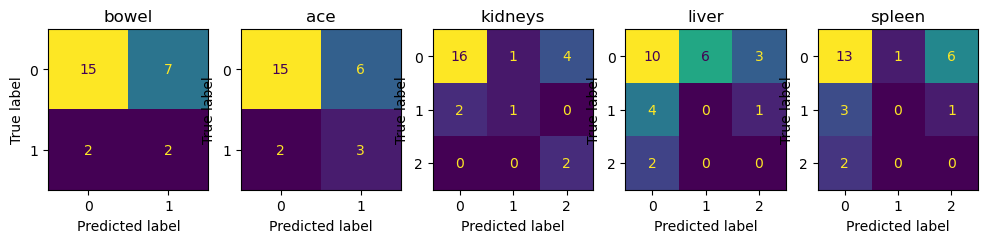

Phase: val


0batch [00:00, ?batch/s]

val: ||
0m 17s
##################################################
Epoch 2/10: 
Phase: train


  0%|          | 0/26 [00:00<?, ?batch/s]

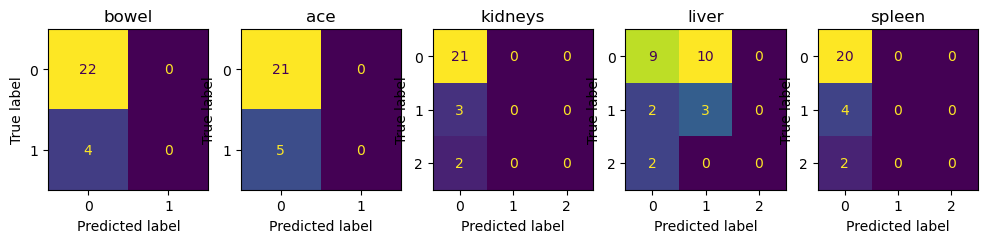

Phase: val


0batch [00:00, ?batch/s]

val: ||
0m 16s
##################################################
Epoch 3/10: 
Phase: train


  0%|          | 0/26 [00:00<?, ?batch/s]

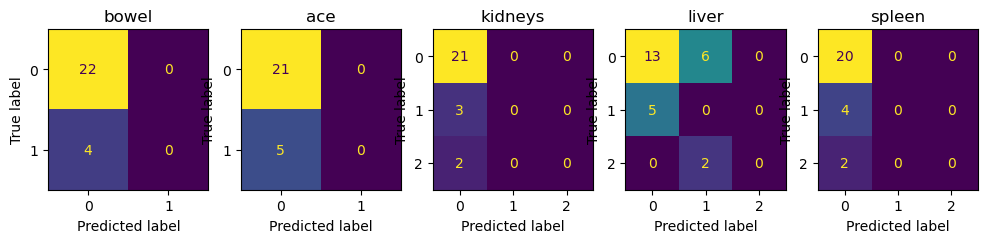

Phase: val


0batch [00:00, ?batch/s]

val: ||
0m 16s
##################################################
Epoch 4/10: 
Phase: train


  0%|          | 0/26 [00:00<?, ?batch/s]

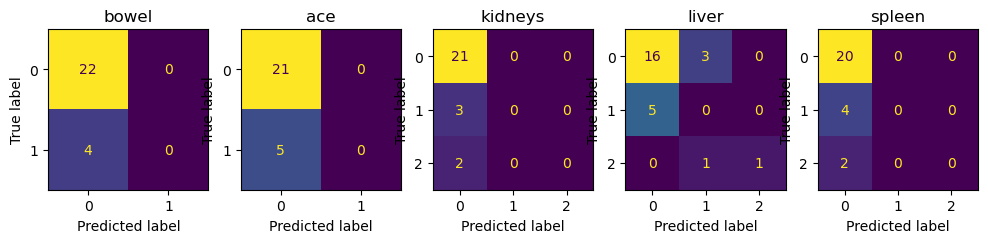

Phase: val


0batch [00:00, ?batch/s]

val: ||
0m 16s
##################################################
Epoch 5/10: 
Phase: train


  0%|          | 0/26 [00:00<?, ?batch/s]

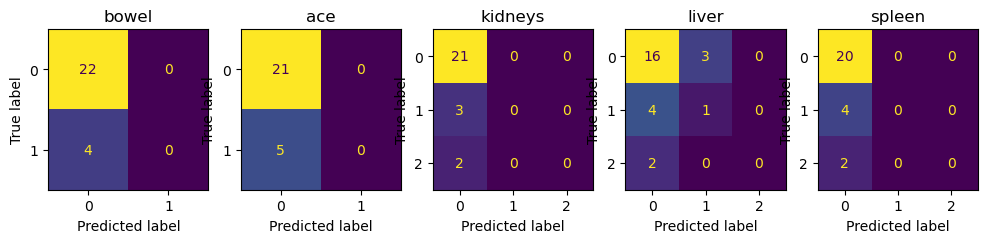

Phase: val


0batch [00:00, ?batch/s]

val: ||
0m 17s
##################################################
Epoch 6/10: 
Phase: train


  0%|          | 0/26 [00:00<?, ?batch/s]

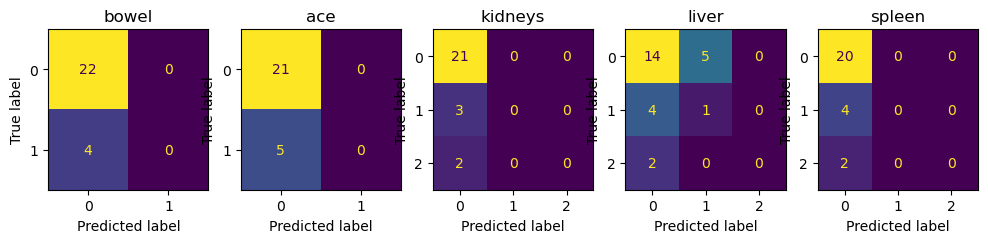

Phase: val


0batch [00:00, ?batch/s]

val: ||
0m 16s
##################################################
Epoch 7/10: 
Phase: train


  0%|          | 0/26 [00:00<?, ?batch/s]

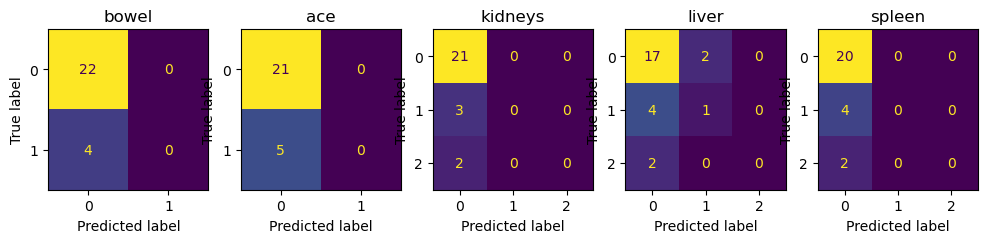

Phase: val


0batch [00:00, ?batch/s]

val: ||
0m 17s
##################################################
Epoch 8/10: 
Phase: train


  0%|          | 0/26 [00:00<?, ?batch/s]

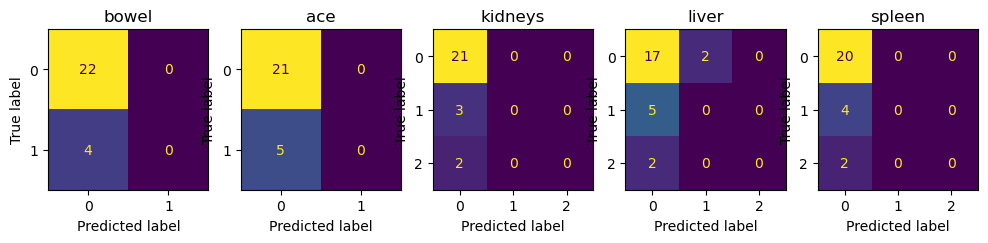

Phase: val


0batch [00:00, ?batch/s]

val: ||
0m 16s
##################################################
Epoch 9/10: 
Phase: train


  0%|          | 0/26 [00:00<?, ?batch/s]

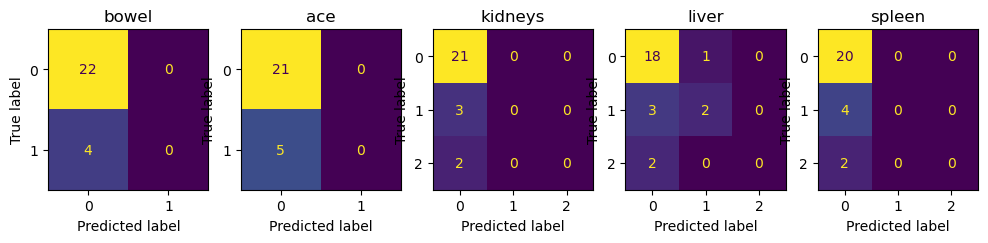

Phase: val


0batch [00:00, ?batch/s]

val: ||
0m 17s
##################################################
Epoch 10/10: 
Phase: train


  0%|          | 0/26 [00:00<?, ?batch/s]

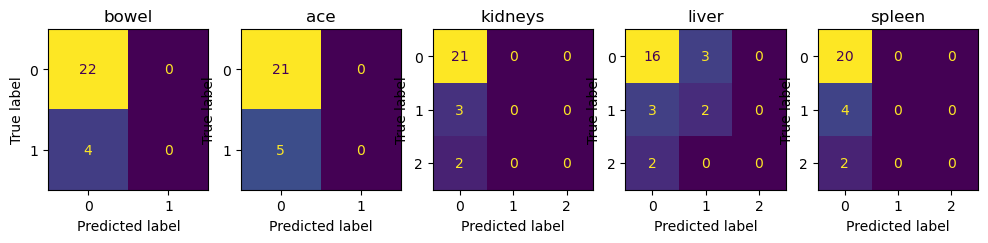

Phase: val


0batch [00:00, ?batch/s]

val: ||
0m 16s
##################################################
Best validation loss: 7.991658


In [93]:
train()

In [91]:
import gc

#model.cpu()


#del model, checkpoint
gc.collect()
torch.cuda.empty_cache()

In [92]:
a = [[0., 1.],
 [1., 0.]]

In [ ]:
for item in a:
    print(np.argmax(item))